1. Prework

a) rename the model files

In [ ]:
%%bash
cd ../scripts/segmentations
bash hcp_rename_model_files.sh --subjects_dir=""

/home/cbuerger/deepRetinotopy_validation/notebooks


b) transform the angles from deepRetinotopy to the required angles for neuropythy

In [ ]:
%%bash
cd ../scripts/segmentations
bash hcp_neuropythy-deepRetinotopy-prework.sh --subjects_dir=""

2. Start with bensons register_retinotopy

In [ ]:
%%bash
cd ../scripts/segmentations
python hcp_neuropythy-deepRetinotopy.py --execute --subjects_dir=""

3. convert the created files to .gii files

In [ ]:
%%bash
cd ../scripts/segmentations
bash hcp_create-gii.sh --subjects_dir=""

4. Calculate the single dice scores, the means and show the mins and maxs

In [ ]:
# compare the empirical with the anatomists and with the deepRetinotopy

import numpy as np
import nibabel as nib
from nibabel import gifti
import os




#Dice(A,B)=  2∣A∩B∣/
#            ∣A∣+∣B∣
def calc_dice_score(array1, array2, mask):
    # calculate the intersection
    a1 = array1[mask == 1]
    a2 = array2[mask == 1]
    
    intersection = np.sum((a1 == 1) & (a2 == 1))
    size1 = np.sum(a1 == 1)
    size2 = np.sum(a2 == 1)
    
    return 2 * intersection / (size1 + size2)



path_to_files = "/BULK/LABDATA/openneuro/nyu4christian/HCP"

# list all subjects
subjects = []
path_to_subjects = "{path_to_files}/subjects".format(path_to_files=path_to_files)
for files in os.listdir(path_to_subjects):
    path = f"{path_to_subjects}/{files}"
    subjects.append(files)
if "927359" in subjects: subjects.remove("927359")
#subjects = ["100610"]


#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=1000)

groups = ["empirical", "deepRetinotopy"]
anatomists = ["A1", "A2", "A3", "A4"]
hemisphere = ['lh', 'rh']
vareas = [1, 2, 3]

# define dictionarys for the maps
maps_anatomists = {sub: {hemi: {anatom: [] for anatom in anatomists} for hemi in hemisphere} for sub in subjects}
maps_groups = {sub: {hemi: {group: [] for group in groups} for hemi in hemisphere} for sub in subjects}
# define dictionarys for the visual area maps
mask_varea_anatomists = {sub: {hemi: {area: {anatom: [] for anatom in anatomists} for area in vareas} for hemi in hemisphere} for sub in subjects}
mask_varea_groups = {sub: {hemi: {area: {group: [] for group in groups} for area in vareas} for hemi in hemisphere} for sub in subjects}
# define dictionary for the mask of the anatomical maps7
mask = {sub: {hemi: [] for hemi in hemisphere} for sub in subjects}
# define dictionary for the dice score
dice_anatom = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_deep = {hemi: {area: {sub: 0 for sub in subjects} for area in vareas} for hemi in hemisphere}


for sub in subjects:
    for hemi in hemisphere:
        # load the dictionarys for the anatomists
        for anatom in anatomists:
            path = "{path_to_subjects}/{sub}/{anatom}.{hemi}.visual_area.gii".format(path_to_subjects=path_to_subjects, sub=sub, anatom=anatom, hemi=hemi)
            array = nib.load(path)
            array = array.agg_data()
            maps_anatomists[sub][hemi][anatom] = array
            
        mask[sub][hemi] = (~np.all([arr == 0 for arr in maps_anatomists[sub][hemi].values()], axis=0)).astype(int)
        # load the dictionarys for empirical
        for group in groups:
            path = "{path_to_files}/freesurfer/{sub}/deepRetinotopy/inferred_{group}/{hemi}.inferred_varea.gii".format(path_to_files=path_to_files, sub=sub, group=group, hemi=hemi)
            array = nib.load(path)
            array = array.agg_data()
            maps_groups[sub][hemi][group] = array                

        
        # calculate the dice score for deepRetinotopy against the four anatomists
        for area in vareas:
            
            # create the maps for the different visual areas
            for group in groups:
                array = maps_groups[sub][hemi][group]
                mask_varea_groups[sub][hemi][area][group] = (array == area).astype(int)
            for anatom in anatomists:
                # create the maps for the different visual areas
                array = maps_anatomists[sub][hemi][anatom]
                mask_varea_anatomists[sub][hemi][area][anatom] = (array == area).astype(int)

                # dice score
                m1 = mask_varea_groups[sub][hemi][area]["empirical"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_anatom[hemi][area][sub][anatom] = dice
                #print(dice)
            m1 = mask_varea_groups[sub][hemi][area]["empirical"]
            m2 = mask_varea_groups[sub][hemi][area]["deepRetinotopy"]
            dice = calc_dice_score(m1, m2, mask[sub][hemi])
            dice_deep[hemi][area][sub] = dice



# calculate the means
mean_in_sub = {hemi: {area: {sub: [] for sub in subjects} for area in vareas} for hemi in hemisphere}
mean_anatom = {hemi: {area: 0 for area in vareas} for hemi in hemisphere}
mean_deep = {hemi: {area: 0 for area in vareas} for hemi in hemisphere}

for hemi in hemisphere:
    for area in vareas:
        for sub in subjects:
            # calculate the mean in every subject over the different anatomists
            dices = dice_anatom[hemi][area][sub].values()
            mean_in_sub[hemi][area][sub] = np.mean(list(dices))
        # calculate the mean of anatomists dice
        dices = mean_in_sub[hemi][area].values()
        mean_anatom[hemi][area] = np.mean(list(dices))
        # calculate the mean of the deepRetinotopy dice
        dices = dice_deep[hemi][area].values()
        mean_deep[hemi][area] = np.mean(list(dices))

        

for hemi in hemisphere:
    for area in vareas:
        print(f"{hemi.upper()} Hemisphere: V{area}")
        mean = mean_anatom[hemi][area]
        score = round(mean, 3)
        print(f"mean of anatomists: {score}")
        mean = mean_deep[hemi][area]
        score = round(mean, 3)
        print(f"mean of deepRetinotopy: {score}")

arten = ["min", "max"]
compares = ["deepRetinotopy", "A1", "A2", "A3", "A4"]
values = {hemi: {area: {comp: {art: 0 for art in arten} for comp in compares} for area in vareas} for hemi in hemisphere}
# calculate min and max
for hemi in hemisphere:
    for area in vareas:
        values_anatom = {anatom: [] for anatom in anatomists}
        values_deep = []
        for sub in subjects:
            values_deep.append(dice_deep[hemi][area][sub])
            for anatom in anatomists:
                values_anatom[anatom].append(dice_anatom[hemi][area][sub][anatom])
        values[hemi][area]["deepRetinotopy"]["min"] = np.min(values_deep)
        values[hemi][area]["deepRetinotopy"]["max"] = np.max(values_deep)
        for anatom in anatomists:
            values[hemi][area][anatom]["min"] = np.min(values_anatom[anatom])
            values[hemi][area][anatom]["max"] = np.max(values_anatom[anatom])
        print(f"{hemi.upper()} Hemisphere: V{area}")
        deep_min = round(values[hemi][area]["deepRetinotopy"]["min"], 3)
        deep_max = round(values[hemi][area]["deepRetinotopy"]["max"], 3)
        print(f"deepRetinotopy: min({deep_min}) max({deep_max})")
        for anatom in anatomists:
            anatom_min = round(values[hemi][area][anatom]["min"], 3)
            anatom_max = round(values[hemi][area][anatom]["max"], 3)
            print(f"{anatom}: min({anatom_min}) max({anatom_max})")
        
        
        
#tmin = values["lh"][1]["deepRetinotopy"]["min"]
#tmax = values["lh"][1]["deepRetinotopy"]["max"]

    





LH Hemisphere: V1
mean of anatomists: 0.85
mean of deepRetinotopy: 0.899
LH Hemisphere: V2
mean of anatomists: 0.684
mean of deepRetinotopy: 0.773
LH Hemisphere: V3
mean of anatomists: 0.624
mean of deepRetinotopy: 0.705
RH Hemisphere: V1
mean of anatomists: 0.846
mean of deepRetinotopy: 0.915
RH Hemisphere: V2
mean of anatomists: 0.671
mean of deepRetinotopy: 0.813
RH Hemisphere: V3
mean of anatomists: 0.627
mean of deepRetinotopy: 0.797
LH Hemisphere: V1
deepRetinotopy: min(0.779) max(0.961)
A1: min(0.674) max(0.929)
A2: min(0.711) max(0.956)
A3: min(0.588) max(0.921)
A4: min(0.599) max(0.94)
LH Hemisphere: V2
deepRetinotopy: min(0.656) max(0.887)
A1: min(0.393) max(0.817)
A2: min(0.401) max(0.85)
A3: min(0.28) max(0.805)
A4: min(0.333) max(0.814)
LH Hemisphere: V3
deepRetinotopy: min(0.281) max(0.866)
A1: min(0.233) max(0.813)
A2: min(0.255) max(0.842)
A3: min(0.303) max(0.833)
A4: min(0.269) max(0.81)
RH Hemisphere: V1
deepRetinotopy: min(0.796) max(0.973)
A1: min(0.657) max(0.926)

5. Create the 1. plot

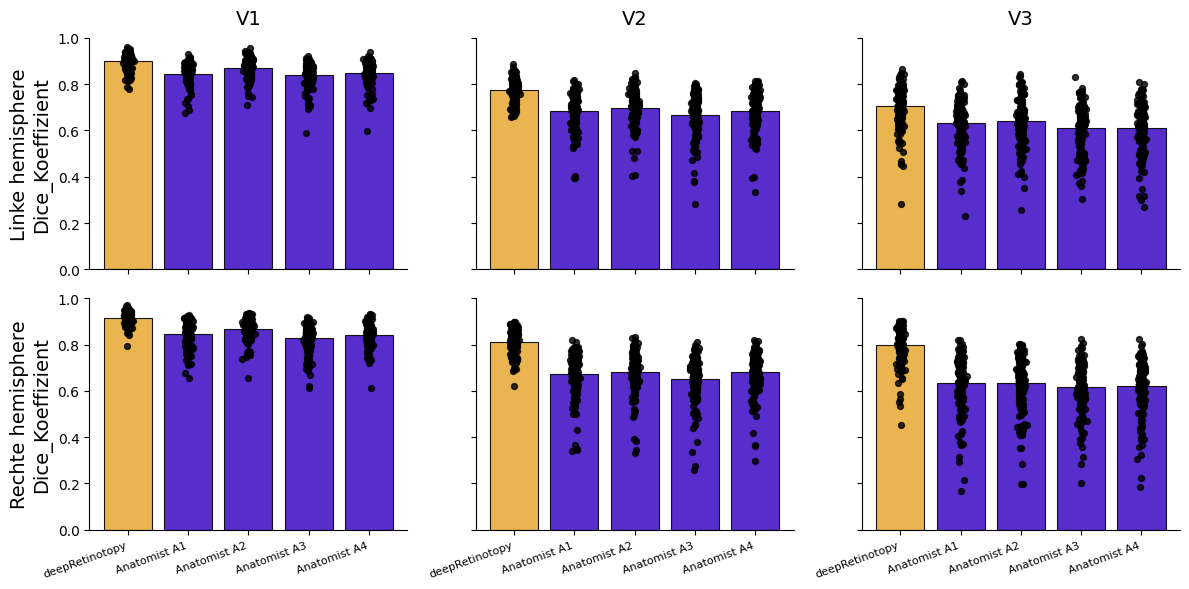

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Liste sammeln für DataFrame
rows = []

for hemi in hemisphere:
    for area in vareas:
        for sub in subjects:
            # deep model (ein Wert)
            rows.append({
                "hemisphere": hemi,
                "area": area,
                "subject": sub,
                "model": "deepRetinotopy",
                "value": dice_deep[hemi][area][sub]
            })
            # anatom models (Mittelwert aus Liste)
            for anatom in anatomists:
                vals = dice_anatom[hemi][area][sub][anatom]
                rows.append({
                    "hemisphere": hemi,
                    "area": area,
                    "subject": sub,
                    "model": f"Anatomist {anatom}",
                    "value": np.mean(vals)
                })

df = pd.DataFrame(rows)

# Standardabweichung
def sem(x):
    x = np.asarray(x)
    return x.std(ddof=1) / np.sqrt(len(x))

models = ["deepRetinotopy"] + [f"Anatomist {a}" for a in anatomists]
xloc = np.arange(len(models))
bar_width = 0.8

# colors
colors = ["#e8ac3d", "#4516c6", "#4516c6", "#4516c6", "#4516c6"]

fig, axes = plt.subplots(len(hemisphere), len(vareas),
                         figsize=(12, 6), sharey=True)

for i, hemi in enumerate(hemisphere):
    for j, area in enumerate(vareas):
        ax = axes[i, j] if axes.ndim == 2 else axes[j]
        
        df_sub = df[(df.hemisphere == hemi) & (df.area == area)]
        stats = df_sub.groupby("model").agg(mean=("value", "mean"),
                                            sem=("value", sem)).reindex(models)

        
        # Fehlerbalken-NaNs in 0 umwandeln
        yerr = stats["sem"].fillna(0).to_numpy()
        means = stats["mean"].fillna(0).to_numpy()
        # Balken
        ax.bar(xloc, means, yerr=yerr, capsize=4,
               width=bar_width, alpha=0.9, edgecolor="black", linewidth=0.8, color=colors)

        # Punkte
        for k, model in enumerate(models):
            vals = df_sub[df_sub.model == model]["value"].values
            jitter = np.random.normal(loc=xloc[k], scale=0.03, size=len(vals))
            ax.scatter(jitter, vals, s=18, color="k", zorder=3, alpha=0.8)

        # Achsen
        if j == 0:
            ax.set_ylabel(f"{'Linke' if hemi=='lh' else 'Rechte'} hemisphere\nDice_Koeffizient", fontsize=14)
        else:
            ax.set_ylabel("")
        
        ax.set_xticks(xloc)
        if i == len(hemisphere)-1:
            ax.set_xticklabels(models, rotation=20, ha="right", fontsize=8)
        else:
            ax.set_xticklabels([])
        
        ax.set_ylim(0, 1.0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

# Spaltenüberschriften
for j, area in enumerate(vareas):
    axes[0, j].set_title(f"V{area}", fontsize=14, pad=10)

fig.tight_layout()
plt.savefig("/home/cbuerger/figure.png", dpi=300, bbox_inches='tight')
plt.show()

6. Create the 2. plot

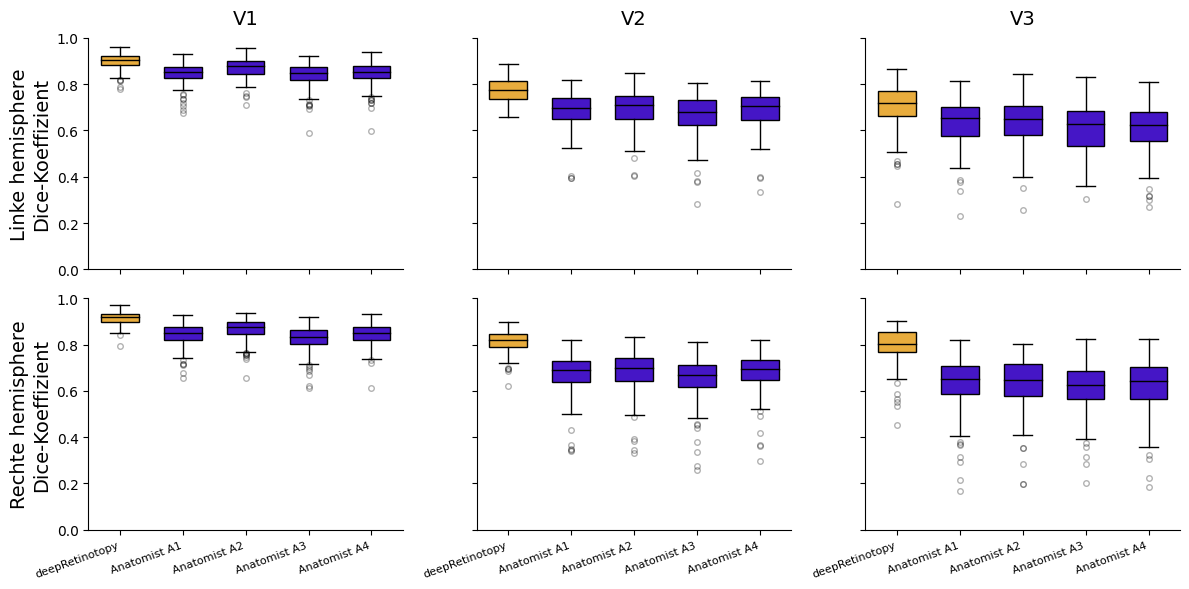

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste sammeln für DataFrame
rows = []

for hemi in hemisphere:
    for area in vareas:
        for sub in subjects:
            # deep model (ein Wert)
            rows.append({
                "hemisphere": hemi,
                "area": area,
                "subject": sub,
                "model": "deepRetinotopy",
                "value": dice_deep[hemi][area][sub]
            })
            # anatom models (Mittelwert aus Liste)
            for anatom in anatomists:
                vals = dice_anatom[hemi][area][sub][anatom]
                rows.append({
                    "hemisphere": hemi,
                    "area": area,
                    "subject": sub,
                    "model": f"Anatomist {anatom}",
                    "value": np.mean(vals)
                })

df = pd.DataFrame(rows)

# Modelle und Farben definieren
models = ["deepRetinotopy"] + [f"Anatomist {a}" for a in anatomists]
colors = ["#e8ac3d", "#4516c6", "#4516c6", "#4516c6", "#4516c6"]
model_color_map = dict(zip(models, colors))

# Boxplot-Figur erstellen
fig, axes = plt.subplots(len(hemisphere), len(vareas), figsize=(12, 6), sharey=True)

for i, hemi in enumerate(hemisphere):
    for j, area in enumerate(vareas):
        ax = axes[i, j] if axes.ndim == 2 else axes[j]

        # Teil-DataFrame für Plot
        df_sub = df[(df.hemisphere == hemi) & (df.area == area)]

        # Daten pro Modell sammeln
        data = [df_sub[df_sub.model == model]["value"].dropna().values for model in models]

        # Boxplot zeichnen
        box = ax.boxplot(data,
                         positions=np.arange(len(models)),
                         patch_artist=True,
                         widths=0.6,
                         medianprops=dict(color="black"),
                         boxprops=dict(linewidth=1),
                         whiskerprops=dict(linewidth=1),
                         capprops=dict(linewidth=1),
                         flierprops=dict(marker='o', markersize=4, alpha=0.3))

        # Farben setzen
        for patch, model in zip(box["boxes"], models):
            patch.set_facecolor(model_color_map[model])
            patch.set_edgecolor("black")

        # Achsenbeschriftung
        if j == 0:
            ax.set_ylabel(f"{'Linke' if hemi=='lh' else 'Rechte'} hemisphere\nDice-Koeffizient", fontsize=14)
        else:
            ax.set_ylabel("")
        
        ax.set_xticks(np.arange(len(models)))
        if i == len(hemisphere) - 1:
            ax.set_xticklabels(models, rotation=20, ha="right", fontsize=8)
        else:
            ax.set_xticklabels([])

        ax.set_ylim(0, 1.0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

# Spaltenüberschriften
for j, area in enumerate(vareas):
    axes[0, j].set_title(f"V{area}", fontsize=14, pad=10)

fig.tight_layout()
plt.savefig("/home/cbuerger/figure_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


7. Create the 3. plot (not sure if it works because I didn't use this one anymore)

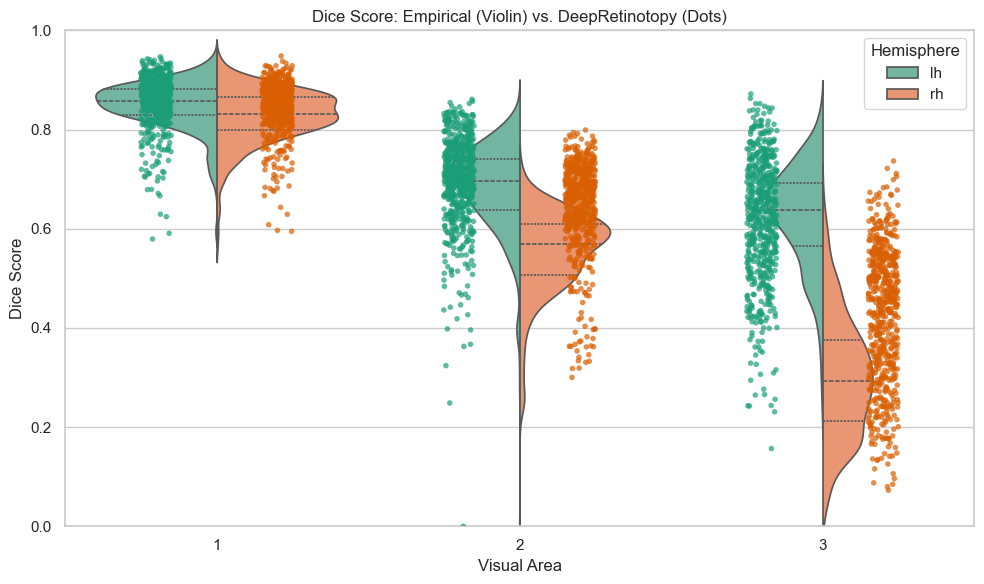

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# create dataframe from dice_score{}
data = []

for hemi in hemisphere:
    for group in groups:
        for area in vareas:
            for sub in subjects:
                for anatom in anatomists:
                    value = dice_score[hemi][group][area][sub][anatom]
                    data.append({
                        'hemisphere': hemi,
                        'group': group,
                        'area': area,
                        'dice_score': value,
                        'subject': sub,
                        'anatom': anatom
                    })

df = pd.DataFrame(data)



# Stil setzen
sns.set(style="whitegrid", palette="muted")

# Nur relevante Daten
empirical_df = df[df['group'] == 'empirical']
deep_df = df[df['group'] == 'deepRetinotopy']

# Violinplot (geteilt: links = left, rechts = right)
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=empirical_df,
    x='area',
    y='dice_score',
    hue='hemisphere',
    split=True,
    inner='quartile',
    palette={'lh': '#66c2a5', 'rh': '#fc8d62'}
)

# Punkte für deepRetinotopy darüber legen
sns.stripplot(
    data=deep_df,
    x='area',
    y='dice_score',
    hue='hemisphere',
    dodge=True,
    marker='o',
    size=4,
    alpha=0.7,
    palette={'lh': '#1b9e77', 'rh': '#d95f02'}
)

# Doppelte Legende entfernen
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Hemisphere")

plt.title("Dice Score: Empirical (Violin) vs. DeepRetinotopy (Dots)")
plt.ylabel("Dice Score")
plt.xlabel("Visual Area")
plt.ylim(0, 1)  # Dice Score liegt typischerweise zwischen 0 und 1
plt.tight_layout()
plt.show()